# Clusterização dos dados de avaliação de filmes - MovieLens 1M

<b>Aluno: Victor Ribeiro </b>
<br>
<b>DRE: 120035521</b>
<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
import requests
import zipfile
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA, TruncatedSVD

# Carregamento dos dados

In [2]:
ML1MZIP_URL = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
ML1MZIP_FILEPATH = 'data/ml-1m.zip'
USERS_FILEPATH = 'data/ml-1m/users.dat'
MOVIES_FILEPATH = 'data/ml-1m/movies.dat'
RATINGS_FILEPATH = 'data/ml-1m/ratings.dat'

In [3]:
def download_files_from_web():
    response = requests.get(ML1MZIP_URL)
    with open(ML1MZIP_FILEPATH, 'wb') as file:
        file.write(response.content)

    with zipfile.ZipFile(ML1MZIP_FILEPATH, 'r') as zip_f:
        zip_f.extractall('data/')

# download_files_from_web()

In [4]:
column_names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users_df = pd.read_csv(USERS_FILEPATH, sep='::', names=column_names, engine='python')
column_names = ['MovieID', 'Title', 'Genres']
movies_df = pd.read_csv(MOVIES_FILEPATH, sep='::', names=column_names, engine='python', encoding='ISO-8859-1')
column_names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df = pd.read_csv(RATINGS_FILEPATH, sep='::', names=column_names, engine='python')
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')

print(users_df.head())
print("-"*150)
print(movies_df.head())
print("-"*150)
print(ratings_df.head())

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455
------------------------------------------------------------------------------------------------------------------------------------------------------
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
---------------------------------------------------------------------------------------------------------------------------------

# Análise exploratória

In [5]:
print(f"Quantidade de filmes: {len(movies_df.index)}")
print(f"Quantidade de usuários: {len(users_df.index)}")
print(f"Quantidade de avaliações: {len(ratings_df.index)}")

Quantidade de filmes: 3883
Quantidade de usuários: 6040
Quantidade de avaliações: 1000209


In [6]:
all_genres = movies_df['Genres'].str.split('|').explode()
distinct_genres = all_genres.unique().tolist()
distinct_genres.sort()
print(f'Gêneros de filmes: {distinct_genres}')

Gêneros de filmes: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


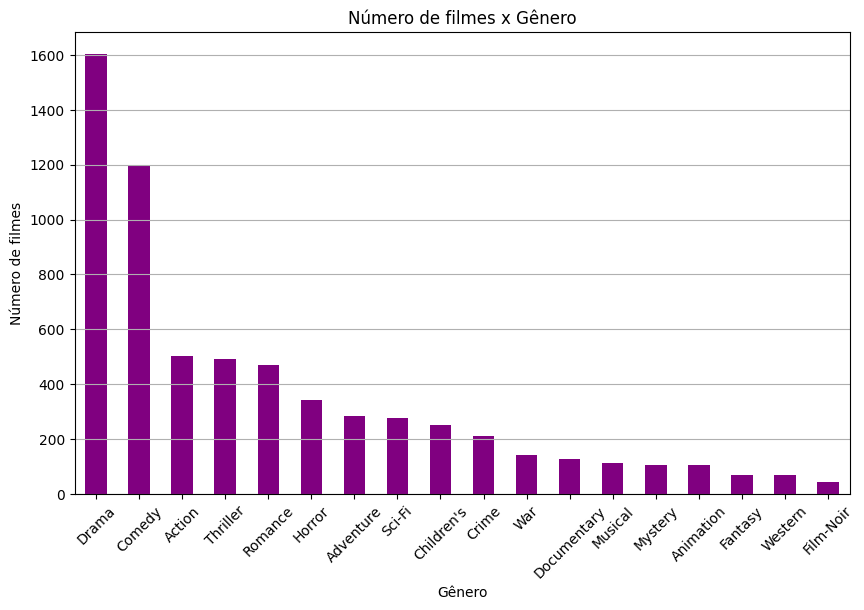

In [7]:
def plot_films_by_genre(df: pd.DataFrame):
   
    expanded_genres = df['Genres'].str.split('|').explode()
    genre_counts = expanded_genres.value_counts()
    
    plt.figure(figsize=(16, 4)) 
    genre_counts.plot(kind='bar', figsize=(10, 6), color='purple')
    plt.title('Número de filmes x Gênero')
    plt.xlabel('Gênero')
    plt.ylabel('Número de filmes')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_films_by_genre(movies_df)

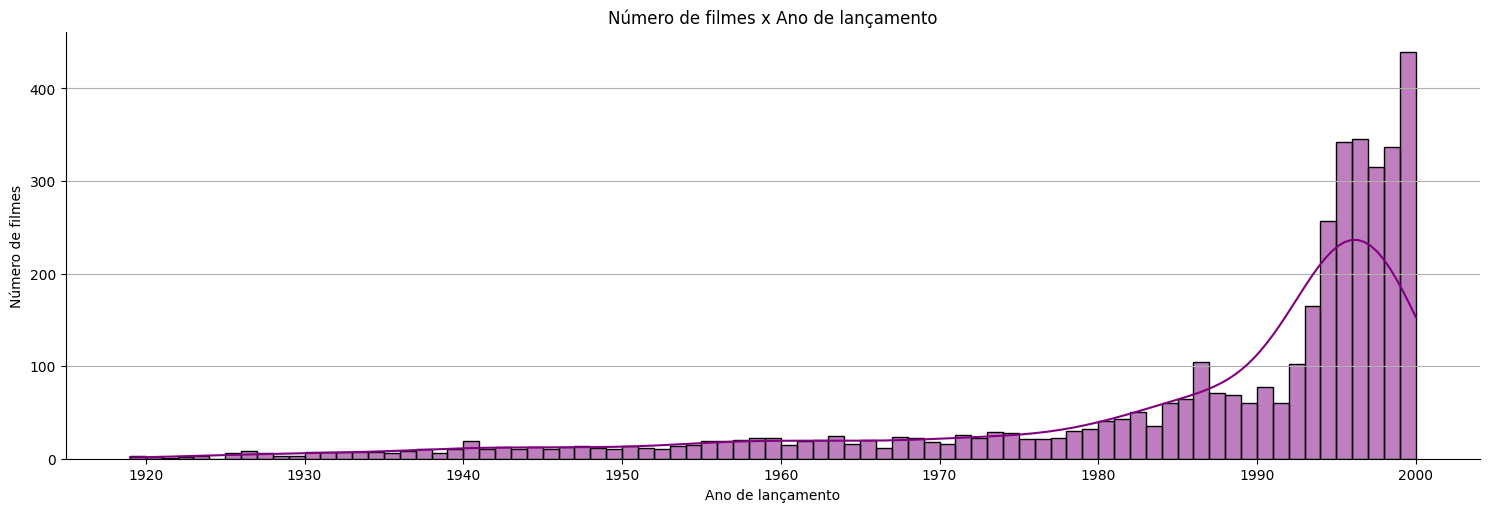

In [8]:
def plot_films_by_year(df: pd.DataFrame):  
    df['Year'] = df['Title'].str.extract(r'\((\d{4})\)').astype(int)

    sns.displot(df, x='Year', binwidth=1, aspect=3, kde=True, color='purple')
    plt.title('Número de filmes x Ano de lançamento')
    plt.xlabel('Ano de lançamento')
    plt.ylabel('Número de filmes')
    plt.grid(axis='y')
    plt.show()

plot_films_by_year(movies_df)

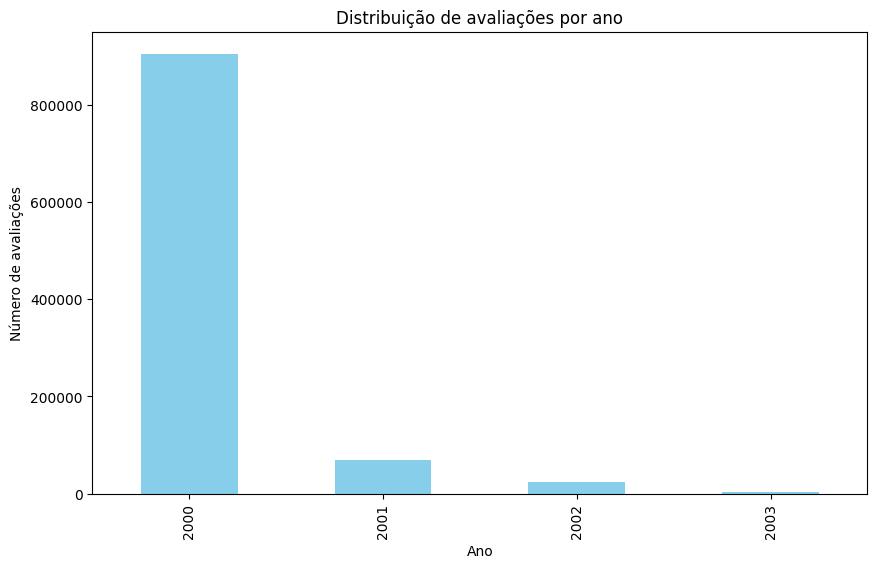

In [9]:
def plot_ratings_by_year(df: pd.DataFrame):
    df['Year'] = df['Timestamp'].dt.year

    # Group by year and count ratings
    ratings_by_year = df.groupby('Year')['Rating'].count()

    # Plot distribution of ratings by year
    ratings_by_year.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.xlabel('Ano')
    plt.ylabel('Número de avaliações')
    plt.title('Distribuição de avaliações por ano')
    plt.show()
plot_ratings_by_year(ratings_df)

In [10]:
ratings_df.duplicated(subset=['UserID', 'MovieID']).any()

False

Sem valores duplicados

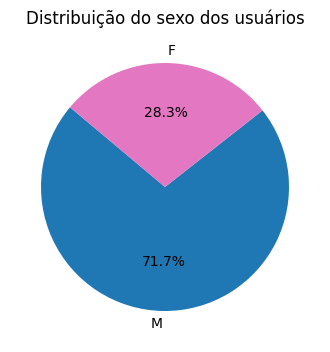

In [11]:
def plot_user_by_genre(df: pd.DataFrame):
    gender_counts = df['Gender'].value_counts()
    plt.figure(figsize=(4, 6))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['tab:blue', 'tab:pink'])
    plt.title('Distribuição do sexo dos usuários')
    plt.show()

plot_user_by_genre(users_df)

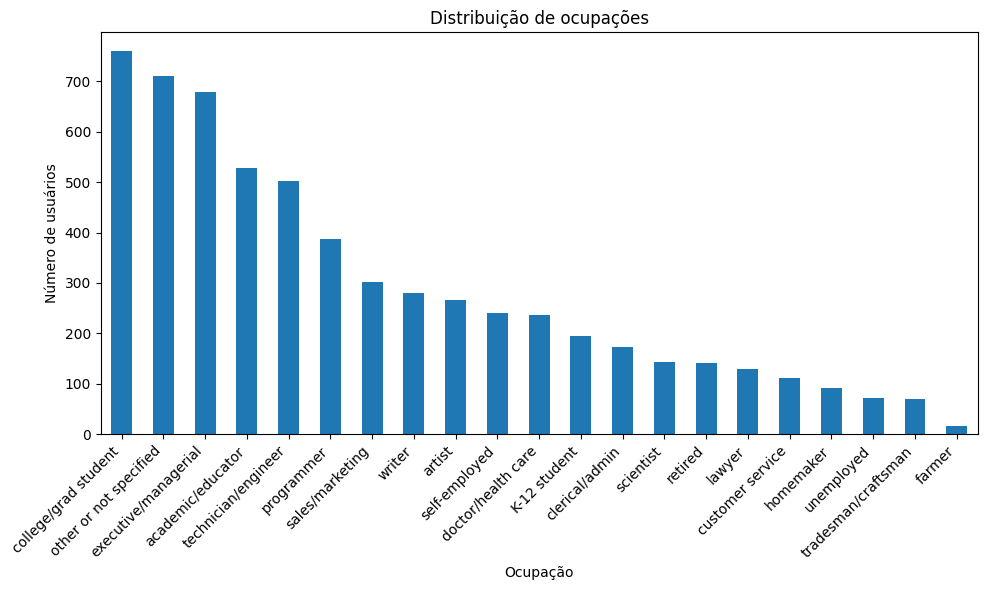

In [12]:
def plot_user_occupation_distribution(df: pd.DataFrame):
    occupation_mapping = {
        0: "other or not specified",
        1: "academic/educator",
        2: "artist",
        3: "clerical/admin",
        4: "college/grad student",
        5: "customer service",
        6: "doctor/health care",
        7: "executive/managerial",
        8: "farmer",
        9: "homemaker",
        10: "K-12 student",
        11: "lawyer",
        12: "programmer",
        13: "retired",
        14: "sales/marketing",
        15: "scientist",
        16: "self-employed",
        17: "technician/engineer",
        18: "tradesman/craftsman",
        19: "unemployed",
        20: "writer"
    }

    df['Occupation_str'] = df['Occupation'].map(occupation_mapping)

    # Count the occurrences of each occupation
    occupation_counts = df['Occupation_str'].value_counts()

    # Plotting a bar chart
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    occupation_counts.plot(kind='bar')
    plt.xlabel('Ocupação')
    plt.ylabel('Número de usuários')
    plt.title('Distribuição de ocupações')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_user_occupation_distribution(users_df)

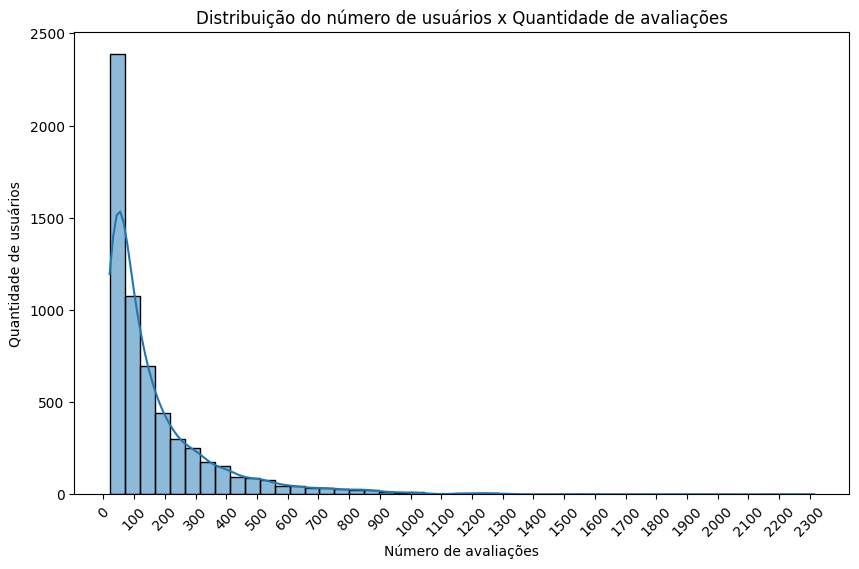

Usuários com menos de 200 avaliações: 4451 -> 73.69% do total.
Usuários com menos de 400 avaliações: 5435 -> 89.98% do total.
Usuários com menos de 600 avaliações: 5781 -> 95.71% do total.
Usuários com menos de 800 avaliações: 5928 -> 98.15% do total.
Usuários com menos de 1000 avaliações: 5999 -> 99.32% do total.


In [13]:
def plot_users_rating_amount_distribution(df: pd.DataFrame):
    # Count number of ratings per user
    ratings_per_user = df['UserID'].value_counts().reset_index()
    ratings_per_user.columns = ['UserID', 'RatingCount']
    # Plotting with Seaborn
    max_rating_count = ratings_per_user['RatingCount'].max()
    bin_width = 50
    num_bins = (max_rating_count // bin_width) + 1
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_per_user['RatingCount'], bins=num_bins, kde=True)
    plt.xlabel('Número de avaliações')
    plt.ylabel('Quantidade de usuários')
    plt.title('Distribuição do número de usuários x Quantidade de avaliações')
    xticks = range(0, max_rating_count + bin_width, bin_width*2)
    plt.xticks(xticks, rotation=45)
    plt.show()

    for count in [200, 400, 600, 800, 1000]:
        qtd = len(ratings_per_user[ratings_per_user['RatingCount'] <  count])
        print(f'Usuários com menos de {count} avaliações: {qtd} -> {qtd*100/len(ratings_per_user.index):.2f}% do total.')

plot_users_rating_amount_distribution(ratings_df)

Esse gráfico fornece uma informação importante: Considerando que 800 é um número consideravelmente alto de avaliações e menos de 2% dos usuários do dataset ultrapassam essa marca, definirei esses usuários como outliers.

## Remoção de outliers

In [14]:
def remove_outliers(df_ratings: pd.DataFrame):
    ratings_per_user = df_ratings['UserID'].value_counts().reset_index()
    ratings_per_user.columns = ['UserID', 'RatingCount']
    ratings_to_remove = ratings_per_user[ratings_per_user['RatingCount']>800]
    print(f'Dataframe antes de remover outliers: {df_ratings.shape}')
    new_df_ratings = df_ratings[~df_ratings['UserID'].isin(ratings_to_remove['UserID'])]
    print(f'Dataframe depois de remover outliers: {new_df_ratings.shape}')
    print(f'Redução de {(len(df_ratings.index)-len(new_df_ratings.index))*100/(len(df_ratings.index)):.2f}% do tamanho original')
    return new_df_ratings
ratings_df_filtered = remove_outliers(ratings_df).drop(columns=['Timestamp'])

Dataframe antes de remover outliers: (1000209, 5)
Dataframe depois de remover outliers: (887764, 5)
Redução de 11.24% do tamanho original


In [15]:
ratings_df_filtered.head()

,UserID,MovieID,Rating,Year
0,1,1193,5,2000
1,1,661,3,2000
2,1,914,3,2000
3,1,3408,4,2000
4,1,2355,5,2001


## Matriz de distâncias

In [16]:
user_movie_matrix = ratings_df_filtered.pivot(index='MovieID', columns='UserID', values='Rating').fillna(0)
user_movie_matrix

UserID,1,2,3,4,5,6,7,8,9,10,...,6030,6031,6032,6033,6034,6035,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalizando dos dados

In [17]:
scaler = StandardScaler()

user_movie_matrix_scaled = scaler.fit_transform(user_movie_matrix)
user_movie_matrix_scaled_df = pd.DataFrame(user_movie_matrix_scaled, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
display(user_movie_matrix_scaled_df.head())

cosine_sim_matrix = pairwise_distances(user_movie_matrix_scaled_df.values, metric='cosine')
cosine_sim_matrix_df = pd.DataFrame(cosine_sim_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.index)
cosine_sim_matrix_df.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6030,6031,6032,6033,6034,6035,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,9.769185,-0.183872,-0.114978,-0.073476,-0.223738,7.151121,-0.090866,5.056070,7.643157,3.469915,...,-0.174432,-0.110426,5.497180,-0.125391,-0.073912,4.706675,-0.234253,-0.071116,-0.182683,2.430770
2,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,-0.192599,-0.168159,3.469915,...,5.492101,-0.110426,-0.165462,-0.125391,-0.073912,-0.246019,-0.234253,-0.071116,-0.182683,-0.302082
3,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,-0.192599,-0.168159,-0.341915,...,-0.174432,-0.110426,-0.165462,-0.125391,-0.073912,0.992154,-0.234253,-0.071116,-0.182683,-0.302082
4,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,3.743903,-0.168159,-0.341915,...,-0.174432,-0.110426,-0.165462,-0.125391,-0.073912,2.230328,-0.234253,-0.071116,-0.182683,-0.302082
5,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,-0.192599,-0.168159,-0.341915,...,-0.174432,-0.110426,-0.165462,-0.125391,-0.073912,0.992154,-0.234253,-0.071116,-0.182683,-0.302082


MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.853441,0.962091,1.096449,0.990014,0.892865,0.915498,1.149636,1.187661,0.860282,...,1.131472,1.417917,1.312666,1.150590,1.175425,0.872484,1.014104,1.173815,1.171766,1.001446
2,0.853441,0.000000,0.971793,1.043827,0.977437,0.967984,0.964867,0.970454,1.054696,0.831085,...,1.060051,1.179820,1.117194,1.062081,1.057381,0.967068,1.010857,1.079305,1.078109,1.016737
3,0.962091,0.971793,0.000000,0.964645,0.897620,1.000784,0.897807,1.026704,1.031315,0.972600,...,1.036436,1.063423,1.054307,1.002839,1.019625,0.966250,1.014179,1.035040,1.039571,1.017263
4,1.096449,1.043827,0.964645,0.000000,0.868231,1.091159,0.945867,0.922224,0.941587,1.082598,...,0.942975,0.797733,0.861096,0.947766,0.943507,1.056095,1.020941,0.938046,0.935644,1.024254
5,0.990014,0.977437,0.897620,0.868231,0.000000,1.045792,0.906631,0.976043,0.983716,0.990886,...,1.008250,0.963062,0.982120,1.006727,1.005892,1.013235,1.005719,1.001040,1.004983,1.008969


## Aplicando K-Médias

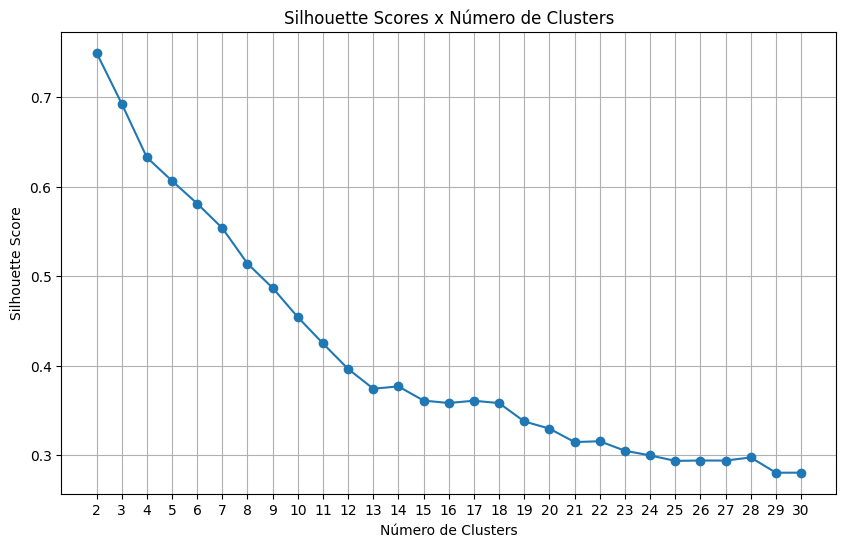

In [18]:
silhouette_list = []

for num_clusters in range(2, 31):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_sim_matrix_df)
    silhouette_avg = silhouette_score(cosine_sim_matrix_df, cluster_labels, metric='cosine')
    silhouette_list.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 31), silhouette_list, marker='o')
plt.title('Silhouette Scores x Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 31))
plt.grid(True)
plt.show()

Usando o K-médias, a divisão em dois clusters é a que apresenta a melhor "shilhouette score". Inspecionando o gráfico, observamos que o score diminui drasticamente com o aumento de número de clusters

## Aplicando DBScan

EPS: 0.5, min_samples: 5
-1    2387
 0    1264
 1      14
 2       9
 3       5
Name: count, dtype: int64
Silhouette Score: 0.08428388679534204
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.5, min_samples: 10
-1    2420
 0    1259
Name: count, dtype: int64
Silhouette Score: 0.14534901387011767
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.6, min_samples: 5
-1    1941
 1    1573
 0     136
 2       7
 3       6
 4       6
 5       5
 6       5
Name: count, dtype: int64
Silhouette Score: 0.12128820620701526
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.6, min_samples: 10
-1    2011
 0    1568
 1      88
 2      12
Name: count, dtype: int64
Silhouette Score: 

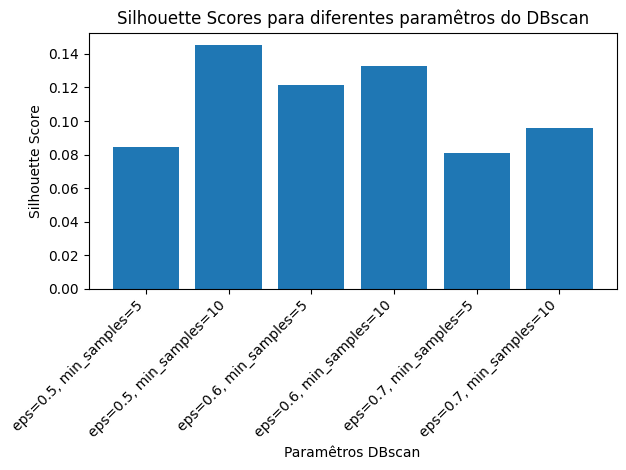

In [19]:
eps_values = [0.5, 0.6, 0.7]
min_samples_values = [5, 10]
silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        clusters = dbscan.fit_predict(cosine_sim_matrix_df)
        
        clusters_series = pd.Series(clusters)
        print(f'EPS: {eps}, min_samples: {min_samples}')
        print(clusters_series.value_counts())
        
        if len(set(clusters)) > 1 and -99 not in set(clusters):
            silhouette_avg = silhouette_score(cosine_sim_matrix_df, clusters, metric='precomputed')
            silhouette_scores.append((eps, min_samples, silhouette_avg))
            print(f'Silhouette Score: {silhouette_avg}')
        else:
            silhouette_scores.append((eps, min_samples, None))
            print('Silhouette Score não pode ser calculado para um único cluster ou apenas ruído.')
        
        print('-'*150)

fig, ax = plt.subplots()
x_labels = [f'eps={eps}, min_samples={min_samples}' for eps, min_samples, _ in silhouette_scores]
y_values = [score if score is not None else 0 for _, _, score in silhouette_scores]
ax.bar(x_labels, y_values)
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Paramêtros DBscan')
ax.set_title('Silhouette Scores para diferentes paramêtros do DBscan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
for eps in [0.5, 0.6, 0.7]:
    for min_samples in [5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        clusters = dbscan.fit_predict(cosine_sim_matrix_df)

        clusters_series = pd.Series(clusters)
        print(f'EPS: {eps}, min_samples:{min_samples}')
        print(clusters_series.value_counts())
        print('-'*150)

EPS: 0.5, min_samples:5
-1    2387
 0    1264
 1      14
 2       9
 3       5
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.5, min_samples:10
-1    2420
 0    1259
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.6, min_samples:5
-1    1941
 1    1573
 0     136
 2       7
 3       6
 4       6
 5       5
 6       5
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.6, min_samples:10
-1    2011
 0    1568
 1      88
 2      12
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------

Apesar da tentativa de variação de epsilon entre 0.1 e 2, com intervalos de 0.1, não encontrei bons resultados (isto é, boa divisão em clusters). O melhor parâmetro encontado foi com eps=0.6, numa divisão entre dois grandes clusters(1941, 1573 filmes) e 6 outros clusters menores.

## Aplicando cluster hierárquico

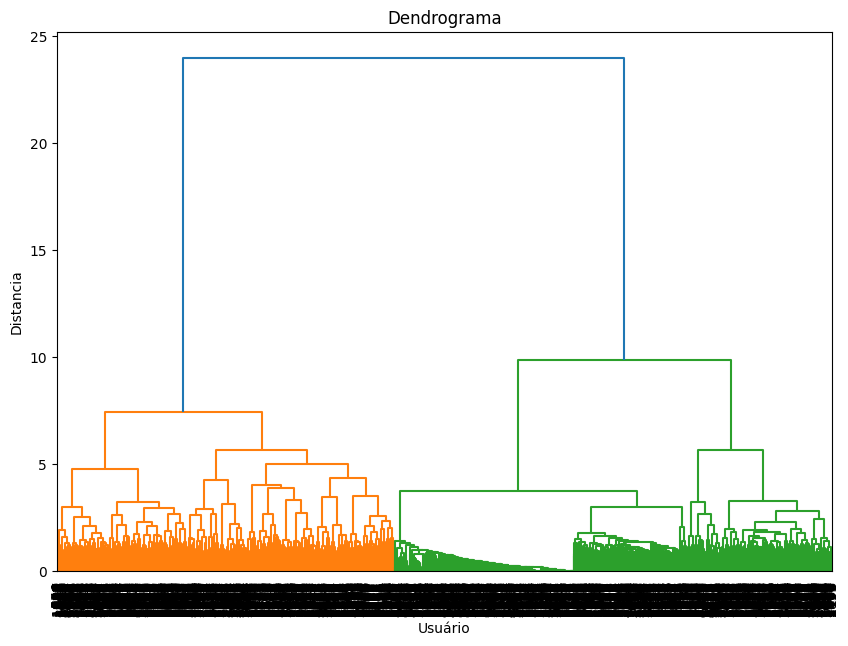

In [21]:
condensed_cosine_sim_matrix = squareform(cosine_sim_matrix, force='tovector', checks=False)

linkage_matrix = linkage(condensed_cosine_sim_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=user_movie_matrix.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrograma')
plt.xlabel('Usuário')
plt.ylabel('Distancia')
plt.show()

## Redução de dimensionalidade

### Usando PCA

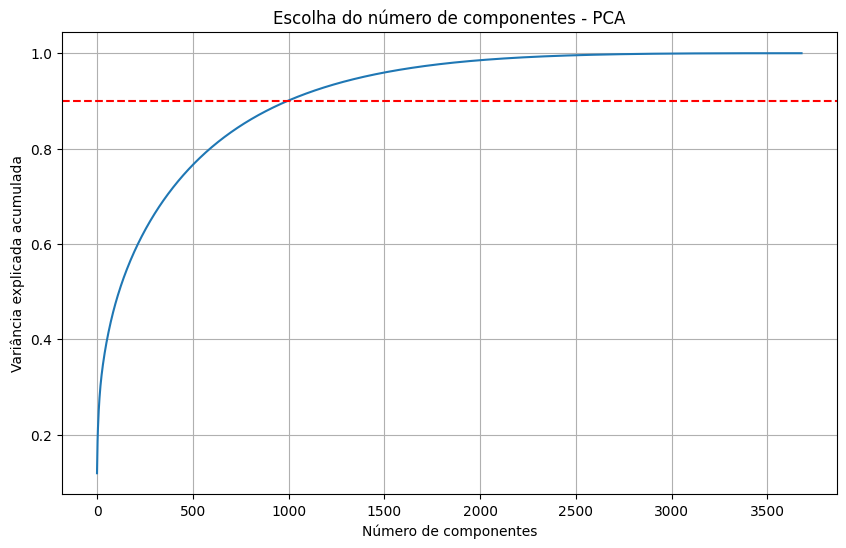

Número de componentes que explicam 90% da variância: 997


In [22]:
pca = PCA().fit(user_movie_matrix_scaled_df)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
percentual_escolhido = 0.9

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('Escolha do número de componentes - PCA')
plt.grid(True)
plt.axhline(y=percentual_escolhido, color='r', linestyle='--')
plt.show()

n_components = np.argmax(cumulative_variance >= percentual_escolhido) + 1
print(f'Número de componentes que explicam 90% da variância: {n_components}')

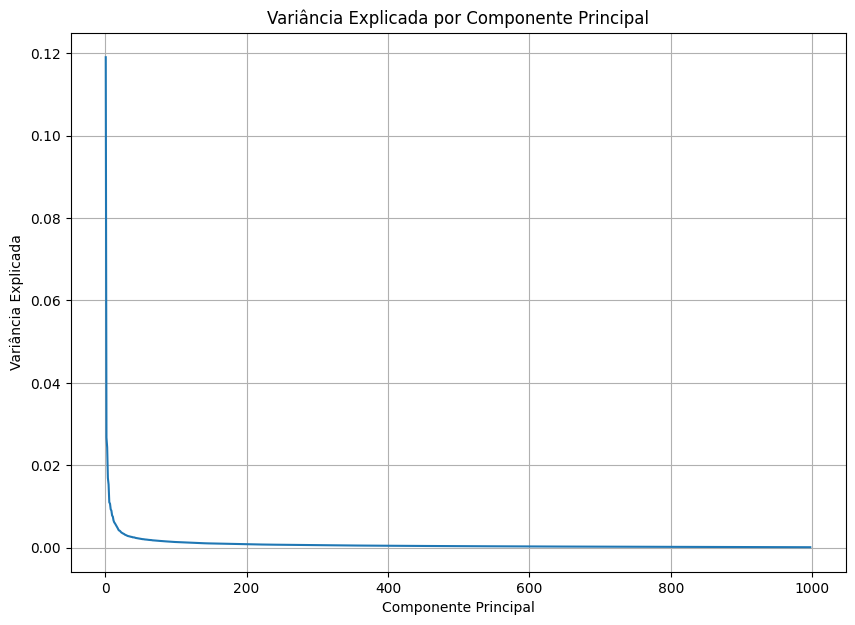

In [23]:
pca = PCA(n_components=n_components)
user_movie_matrix_reduced = pca.fit_transform(user_movie_matrix_scaled_df)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))
plt.plot(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.title('Variância Explicada por Componente Principal')
plt.grid(True)
plt.show()

### Usando SVD

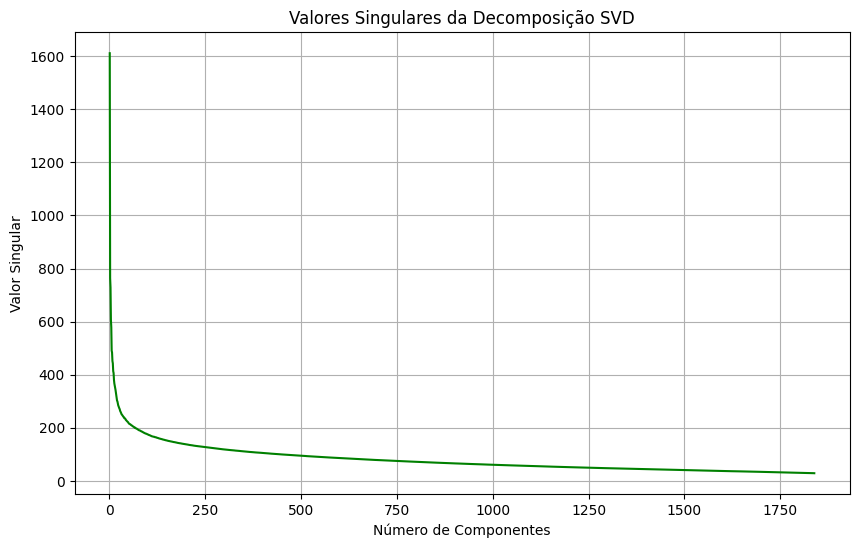

In [24]:
n_components = len(user_movie_matrix_scaled_df.index)//2

svd = TruncatedSVD(n_components=n_components)
svd.fit(user_movie_matrix_scaled_df)
singular_values = svd.singular_values_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(singular_values) + 1), singular_values, color='green')
plt.xlabel('Número de Componentes')
plt.ylabel('Valor Singular')
plt.title('Valores Singulares da Decomposição SVD')
plt.grid(True)
plt.show()

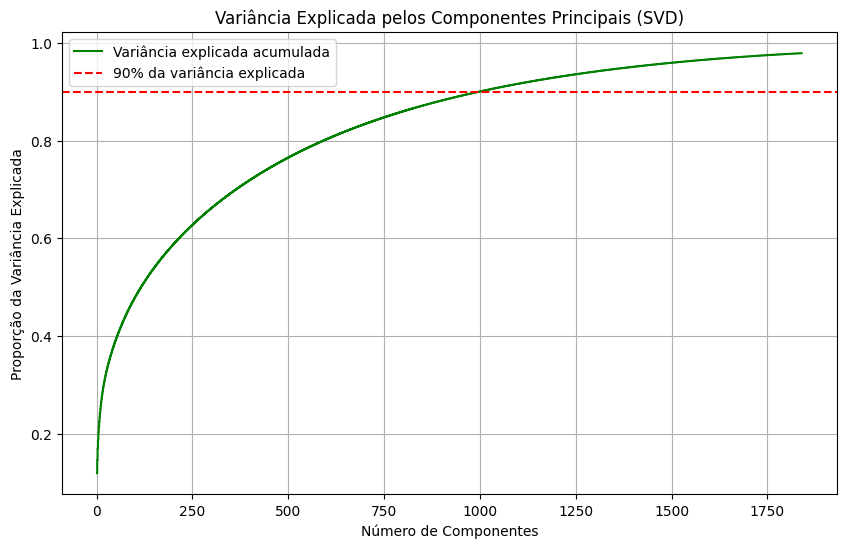

Número de componentes que explicam 90% da variância: 997


In [25]:
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotar variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Variância explicada acumulada', color='green')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% da variância explicada')
plt.xlabel('Número de Componentes')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais (SVD)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Imprimir o número de componentes para 95% da variância
n_components_svd = np.argmax(cumulative_variance >= 0.9) + 1
print(f'Número de componentes que explicam 90% da variância: {n_components_svd}')

Utilizaremos a redução por PCA, pois os resultados foram parecidos com o SVD.

In [26]:
pca = PCA(n_components=550)
user_movie_matrix_reduced = pca.fit_transform(user_movie_matrix_scaled_df)
user_movie_matrix_reduced_df = pd.DataFrame(user_movie_matrix_scaled, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
display(user_movie_matrix_reduced_df.head())

cosine_sim_matrix_reduced = pairwise_distances(user_movie_matrix_reduced_df.values, metric='cosine')
cosine_sim_matrix_df_reduced = pd.DataFrame(cosine_sim_matrix_reduced, index=user_movie_matrix_reduced_df.index, columns=user_movie_matrix_reduced_df.index)
cosine_sim_matrix_df_reduced.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6030,6031,6032,6033,6034,6035,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,9.769185,-0.183872,-0.114978,-0.073476,-0.223738,7.151121,-0.090866,5.056070,7.643157,3.469915,...,-0.174432,-0.110426,5.497180,-0.125391,-0.073912,4.706675,-0.234253,-0.071116,-0.182683,2.430770
2,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,-0.192599,-0.168159,3.469915,...,5.492101,-0.110426,-0.165462,-0.125391,-0.073912,-0.246019,-0.234253,-0.071116,-0.182683,-0.302082
3,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,-0.192599,-0.168159,-0.341915,...,-0.174432,-0.110426,-0.165462,-0.125391,-0.073912,0.992154,-0.234253,-0.071116,-0.182683,-0.302082
4,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,3.743903,-0.168159,-0.341915,...,-0.174432,-0.110426,-0.165462,-0.125391,-0.073912,2.230328,-0.234253,-0.071116,-0.182683,-0.302082
5,-0.119340,-0.183872,-0.114978,-0.073476,-0.223738,-0.137188,-0.090866,-0.192599,-0.168159,-0.341915,...,-0.174432,-0.110426,-0.165462,-0.125391,-0.073912,0.992154,-0.234253,-0.071116,-0.182683,-0.302082


MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.853441,0.962091,1.096449,0.990014,0.892865,0.915498,1.149636,1.187661,0.860282,...,1.131472,1.417917,1.312666,1.150590,1.175425,0.872484,1.014104,1.173815,1.171766,1.001446
2,0.853441,0.000000,0.971793,1.043827,0.977437,0.967984,0.964867,0.970454,1.054696,0.831085,...,1.060051,1.179820,1.117194,1.062081,1.057381,0.967068,1.010857,1.079305,1.078109,1.016737
3,0.962091,0.971793,0.000000,0.964645,0.897620,1.000784,0.897807,1.026704,1.031315,0.972600,...,1.036436,1.063423,1.054307,1.002839,1.019625,0.966250,1.014179,1.035040,1.039571,1.017263
4,1.096449,1.043827,0.964645,0.000000,0.868231,1.091159,0.945867,0.922224,0.941587,1.082598,...,0.942975,0.797733,0.861096,0.947766,0.943507,1.056095,1.020941,0.938046,0.935644,1.024254
5,0.990014,0.977437,0.897620,0.868231,0.000000,1.045792,0.906631,0.976043,0.983716,0.990886,...,1.008250,0.963062,0.982120,1.006727,1.005892,1.013235,1.005719,1.001040,1.004983,1.008969


## Reaplicando os algoritmos de clusterização

### Usando K-médias

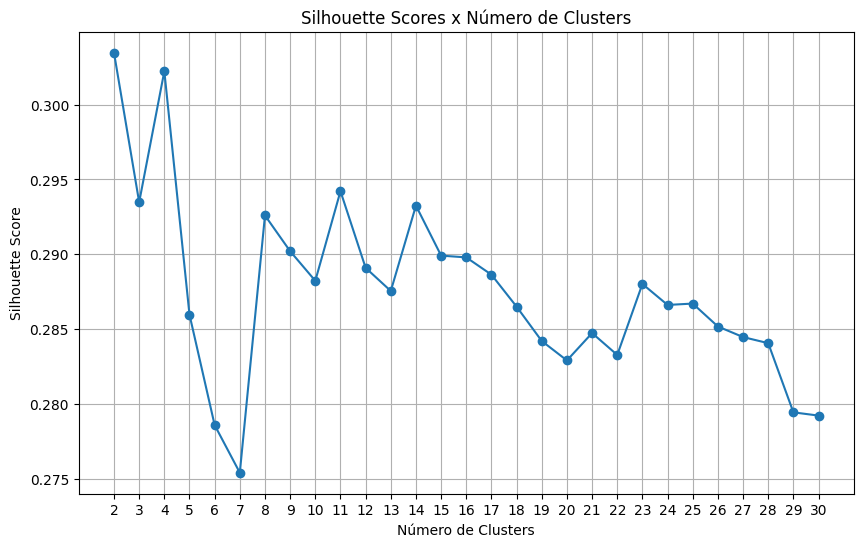

In [27]:
silhouette_list = []

# Step 3: Vary the number of clusters from 2 to 30 and compute silhouette scores
for num_clusters in range(2, 31):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(user_movie_matrix_reduced)
    silhouette_avg = silhouette_score(user_movie_matrix_reduced, cluster_labels, metric='cosine')
    silhouette_list.append(silhouette_avg)

# Step 4: Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 31), silhouette_list, marker='o')
plt.title('Silhouette Scores x Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 31))
plt.grid(True)
plt.show()

### Usando DBScan

EPS: 0.5, min_samples: 5
-1    2387
 0    1264
 1      14
 2       9
 3       5
Name: count, dtype: int64
Silhouette Score: 0.08428388679534204
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.5, min_samples: 10
-1    2420
 0    1259
Name: count, dtype: int64
Silhouette Score: 0.14534901387011767
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.6, min_samples: 5
-1    1941
 1    1573
 0     136
 2       7
 3       6
 4       6
 5       5
 6       5
Name: count, dtype: int64
Silhouette Score: 0.12128820620701526
------------------------------------------------------------------------------------------------------------------------------------------------------
EPS: 0.6, min_samples: 10
-1    2011
 0    1568
 1      88
 2      12
Name: count, dtype: int64
Silhouette Score: 

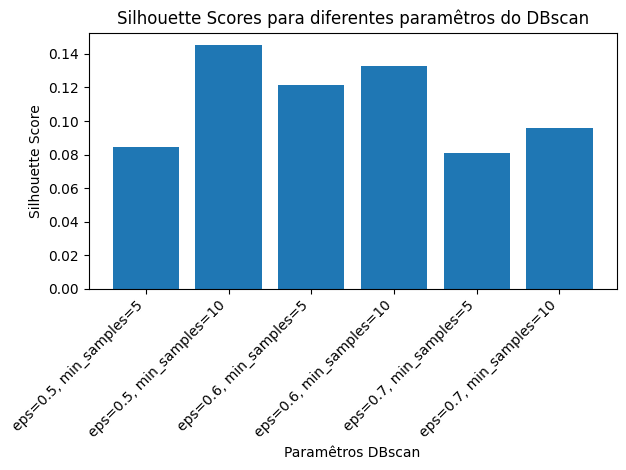

In [28]:
eps_values = [0.5, 0.6, 0.7]
min_samples_values = [5, 10]
silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        clusters = dbscan.fit_predict(cosine_sim_matrix_df_reduced)
        
        # Convertendo os clusters em uma série pandas para contar os rótulos
        clusters_series = pd.Series(clusters)
        print(f'EPS: {eps}, min_samples: {min_samples}')
        print(clusters_series.value_counts())
        
        # Calculando o Silhouette Score se houver mais de um cluster e sem considerar ruído
        if len(set(clusters)) > 1 and -99 not in set(clusters):
            silhouette_avg = silhouette_score(cosine_sim_matrix_df_reduced, clusters, metric='precomputed')
            silhouette_scores.append((eps, min_samples, silhouette_avg))
            print(f'Silhouette Score: {silhouette_avg}')
        else:
            silhouette_scores.append((eps, min_samples, None))
            print('Silhouette Score não pode ser calculado para um único cluster ou apenas ruído.')
        
        print('-'*150)

# Plotando os Silhouette Scores
fig, ax = plt.subplots()
x_labels = [f'eps={eps}, min_samples={min_samples}' for eps, min_samples, _ in silhouette_scores]
y_values = [score if score is not None else 0 for _, _, score in silhouette_scores]

ax.bar(x_labels, y_values)
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Paramêtros DBscan')
ax.set_title('Silhouette Scores para diferentes paramêtros do DBscan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


### Usando Cluster hierárquico

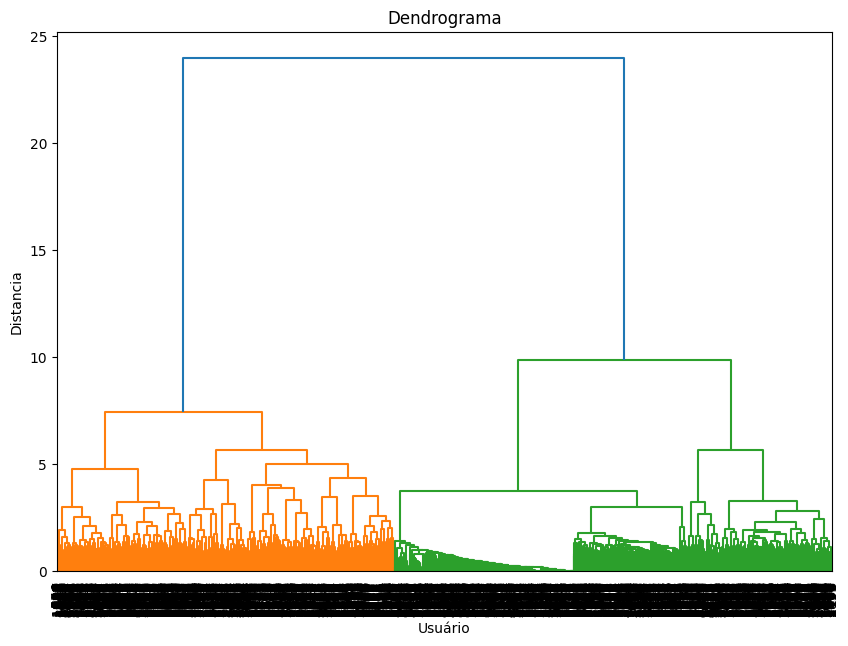

In [29]:
condensed_cosine_sim_matrix = squareform(cosine_sim_matrix_reduced, force='tovector', checks=False)

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_cosine_sim_matrix, method='ward')  # 'ward' can be replaced with 'single', 'complete', 'average', etc.
    
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=user_movie_matrix.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrograma')
plt.xlabel('Usuário')
plt.ylabel('Distancia')
plt.show()

## Análise dos Clusters
A clusterização que ofereceu melhores resultados, foi usando K-médias após a redução de dimensionalidade. Portanto, usaremos K-médias com 8 clusters, pois no gráfico demonstrou uma boa avaliação de silhouette score e possui uma boa quantidade de clusters para analisar (diferente do caso com 2 clusters).

In [30]:

kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(user_movie_matrix_reduced)
print("Contagem de filmes por cluster")
display(pd.Series(clusters).value_counts())

clusters_df = pd.DataFrame({'MovieID': user_movie_matrix_reduced_df.index, 'Cluster': clusters})

movies_df_filtered = movies_df[movies_df['MovieID'].isin(ratings_df_filtered['MovieID'].unique())]
movies_df_clustered = movies_df_filtered.merge(clusters_df, on='MovieID', how='left')

display(movies_df_clustered.head())

Contagem de filmes por cluster


0    2901
1     392
2     234
3     113
5      12
4      10
6      10
7       7
Name: count, dtype: int64

,MovieID,Title,Genres,Year,Cluster
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,3
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,1
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,1
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0


In [31]:
genres_df = movies_df_clustered['Genres'].str.get_dummies(sep='|')
genres_df['Cluster'] = movies_df_clustered['Cluster']
cluster_genre_distribution = genres_df.groupby('Cluster').sum()

### Cluster 3
O cluster 3 só obteve 5 filmes agrupados. Porém, o agrupamento parece fazer bastante sentido já quase todos os filmes são de comédia.

,MovieID,Title,Genres,Year,Cluster
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,3
10,11,"American President, The (1995)",Comedy|Drama|Romance,1995,3
20,21,Get Shorty (1995),Action|Comedy|Drama,1995,3
31,32,Twelve Monkeys (1995),Drama|Sci-Fi,1995,3
33,34,Babe (1995),Children's|Comedy|Drama,1995,3
38,39,Clueless (1995),Comedy|Romance,1995,3
46,47,Seven (Se7en) (1995),Crime|Thriller,1995,3
144,150,Apollo 13 (1995),Drama,1995,3
216,223,Clerks (1994),Comedy,1994,3
345,356,Forrest Gump (1994),Comedy|Romance|War,1994,3


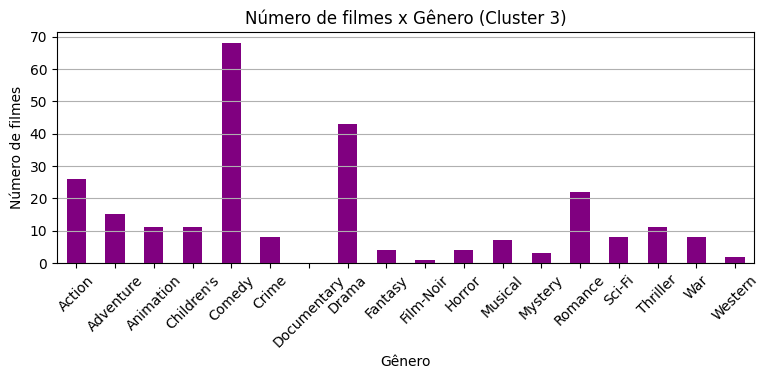

In [32]:
cluster = 3
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Cluster 7
O cluster 7 possui filmes principalmente de ação e ficção científica, com um total de 8 filmes no cluster.

,MovieID,Title,Genres,Year,Cluster
308,318,"Shawshank Redemption, The (1994)",Drama,1994,7
512,527,Schindler's List (1993),Drama|War,1993,7
577,593,"Silence of the Lambs, The (1991)",Drama|Thriller,1991,7
1833,2028,Saving Private Ryan (1998),Action|Drama|War,1998,7
2186,2396,Shakespeare in Love (1998),Comedy|Romance,1998,7
2538,2762,"Sixth Sense, The (1999)",Thriller,1999,7
2632,2858,American Beauty (1999),Comedy|Drama,1999,7


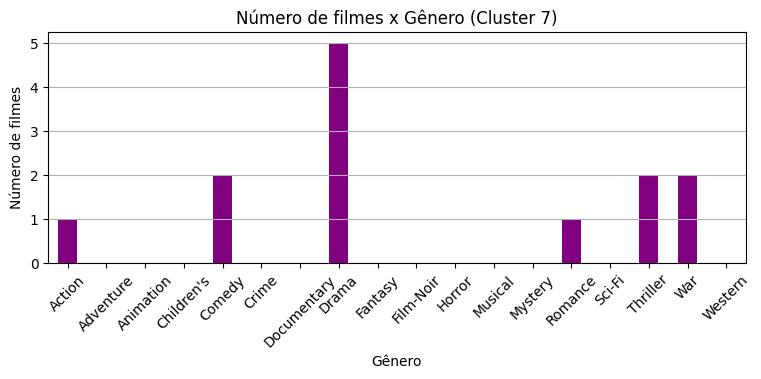

In [33]:
cluster = 7
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Cluster 2
No cluster 2, é interessante notar que a distribuição de gêneros é bem parecida com o do cluster 7, apesar de ter o dobro do número de filmes. Talvez, em um melhor agrupamento estes dois clusters fizessem parte do mesmo grupo. Interessante notar também a presença de tres filmes do Star Wars (IV, V, VI) neste cluster.

,MovieID,Title,Genres,Year,Cluster
16,17,Sense and Sensibility (1995),Drama|Romance,1995,2
24,25,Leaving Las Vegas (1995),Drama|Romance,1995,2
35,36,Dead Man Walking (1995),Drama,1995,2
56,58,"Postino, Il (The Postman) (1994)",Drama|Romance,1994,2
107,111,Taxi Driver (1976),Drama|Thriller,1976,2
156,162,Crumb (1994),Documentary,1994,2
228,235,Ed Wood (1994),Comedy|Drama,1994,2
239,246,Hoop Dreams (1994),Documentary,1994,2
240,247,Heavenly Creatures (1994),Drama|Fantasy|Romance|Thriller,1994,2
258,265,Like Water for Chocolate (Como agua para choco...,Drama|Romance,1992,2


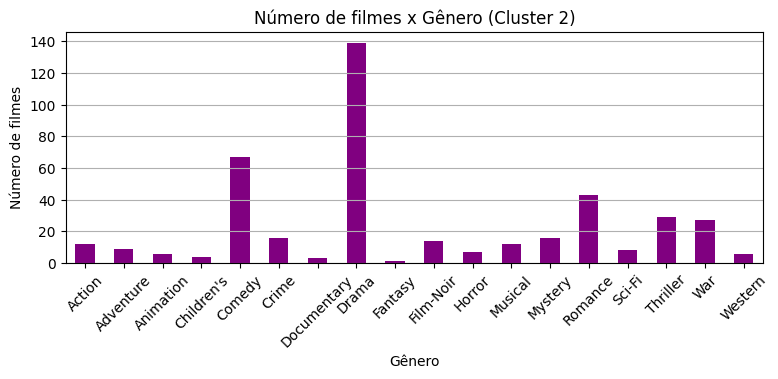

In [34]:
cluster = 2
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Cluster 1
Neste cluster, é nítido o agrupamento por filmes de animação, infantis e musicais. Talvez fosse um bom ponto de partida para buscar recomendação de filmes para esta faixa etária. Apesar disso, o filme "...E o vento levou", aparece neste cluster.

,MovieID,Title,Genres,Year,Cluster
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,1
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,1
5,6,Heat (1995),Action|Crime|Thriller,1995,1
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,1
15,16,Casino (1995),Drama|Thriller,1995,1
23,24,Powder (1995),Drama|Sci-Fi,1995,1
28,29,"City of Lost Children, The (1995)",Adventure|Sci-Fi,1995,1
60,62,Mr. Holland's Opus (1995),Drama,1995,1
68,70,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller,1996,1
92,95,Broken Arrow (1996),Action|Thriller,1996,1


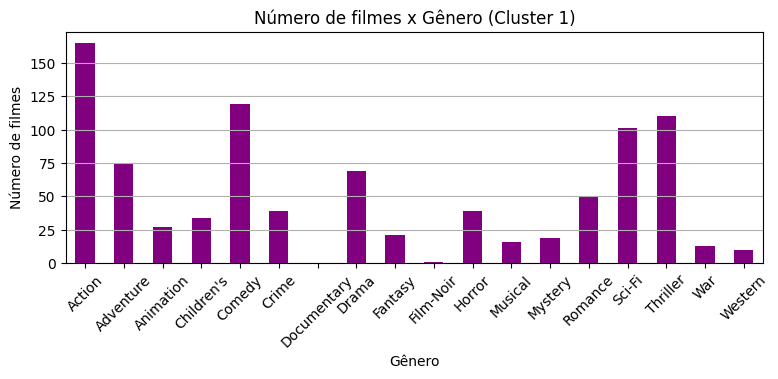

In [35]:
cluster = 1
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Cluster 5
O cluster 5 aparentemente possui um grupo de filmes divididos entre comédias e dramas.

,MovieID,Title,Genres,Year,Cluster
49,50,"Usual Suspects, The (1995)",Crime|Thriller,1995,5
287,296,Pulp Fiction (1994),Crime|Drama,1994,5
591,608,Fargo (1996),Crime|Drama|Thriller,1996,5
794,858,"Godfather, The (1972)",Action|Crime|Drama,1972,5
1009,1089,Reservoir Dogs (1992),Crime|Thriller,1992,5
1096,1193,One Flew Over the Cuckoo's Nest (1975),Drama,1975,5
1115,1213,GoodFellas (1990),Crime|Drama,1990,5
1123,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama,1974,5
1474,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1997,5
1551,1704,Good Will Hunting (1997),Drama,1997,5


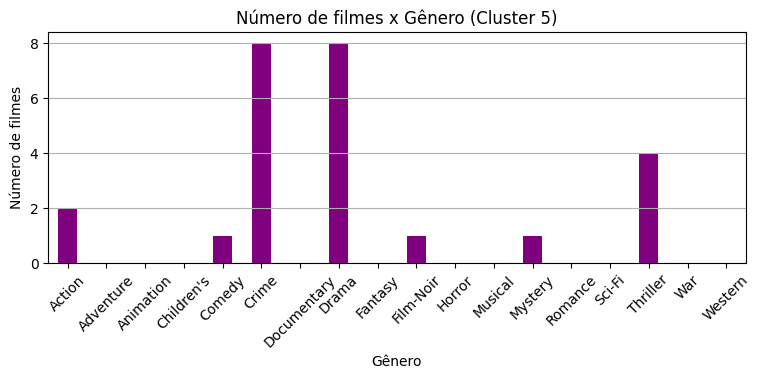

In [36]:
cluster = 5
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Cluster 6
Neste cluster, é possível notar um grande número de filmes de ação, ficção científica e terror. Parece ser um cluster coeso com 135 filmes.

,MovieID,Title,Genres,Year,Cluster
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1977,6
526,541,Blade Runner (1982),Film-Noir|Sci-Fi,1982,6
855,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,1968,6
1017,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,6
1098,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1980,6
1102,1200,Aliens (1986),Action|Sci-Fi|Thriller|War,1986,6
1112,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1983,6
1116,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller,1979,6
1140,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,1984,6
1170,1270,Back to the Future (1985),Comedy|Sci-Fi,1985,6


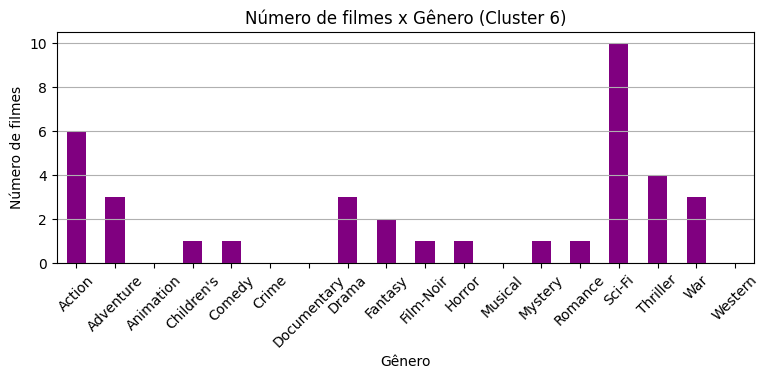

In [37]:
cluster = 6
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Cluster 0 e 4
Os clusters 0 e 4 não parecem ter obtido um bom agrupamento, visto que os gêneros estão bem dispersos nos clusters. Além disso, o cluster 4 possui 2964 filmes, o que pode indicar um agrupamento falho. Ao analisar a distribuição de gêneros nesses clusters, podemos perceber que é bem parecida com a distribuição do dataset inteiro, o que talvez indique que não foram bons agrupamentos.

,MovieID,Title,Genres,Year,Cluster
106,110,Braveheart (1995),Action|Drama|War,1995,4
442,457,"Fugitive, The (1993)",Action|Thriller,1993,4
465,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1993,4
573,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,1991,4
1100,1198,Raiders of the Lost Ark (1981),Action|Adventure,1981,4
1438,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,1997,4
1467,1610,"Hunt for Red October, The (1990)",Action|Thriller,1990,4
2356,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,4
2407,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,1999,4
2689,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,1990,4


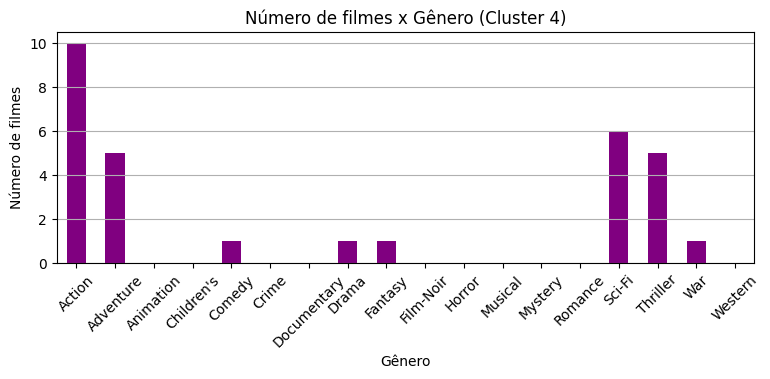

,MovieID,Title,Genres,Year,Cluster
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0
6,7,Sabrina (1995),Comedy|Romance,1995,0
7,8,Tom and Huck (1995),Adventure|Children's,1995,0
8,9,Sudden Death (1995),Action,1995,0
11,12,Dracula: Dead and Loving It (1995),Comedy|Horror,1995,0
12,13,Balto (1995),Animation|Children's,1995,0
13,14,Nixon (1995),Drama,1995,0
14,15,Cutthroat Island (1995),Action|Adventure|Romance,1995,0
17,18,Four Rooms (1995),Thriller,1995,0


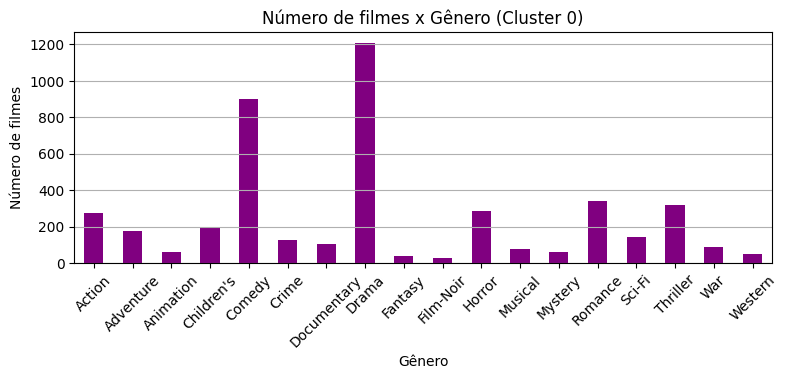

In [38]:
cluster = 4
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

cluster = 0
data = cluster_genre_distribution.iloc[cluster]
display(movies_df_clustered[movies_df_clustered['Cluster']==cluster].head(10))

data.plot(kind='bar', figsize=(9, 3), color='purple')
plt.title(f'Número de filmes x Gênero (Cluster {cluster})')
plt.xlabel('Gênero')
plt.ylabel('Número de filmes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()